In [1]:
import re
import pandas as pd
import datetime as dt
from psaw import PushshiftAPI

api = PushshiftAPI()

## Note!! Here I am searching for Fitbit, just to identify subreddits to search so they should all mention Fitbit. Not to be used for lifts

In [2]:
gen = api.search_comments(after=int(dt.datetime(2019, 10, 1).timestamp()),
                             before = int(dt.datetime(2019, 11, 30).timestamp()),
                             q = "Fitbit",
                             limit = 10000)


df_fitbit = pd.DataFrame([obj.d_ for obj in gen])

In [3]:
df_fitbit.columns

Index(['all_awardings', 'associated_award', 'author',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_patreon_flair', 'awarders', 'body',
       'collapsed_because_crowd_control', 'created_utc', 'gildings', 'id',
       'is_submitter', 'link_id', 'locked', 'no_follow', 'parent_id',
       'permalink', 'retrieved_on', 'score', 'send_replies', 'steward_reports',
       'stickied', 'subreddit', 'subreddit_id', 'total_awards_received',
       'created', 'distinguished', 'author_cakeday', 'edited'],
      dtype='object')

In [4]:
len(df_fitbit)

8950

In [5]:
df_fitbit['body'].str.contains('google', flags=re.IGNORECASE, regex=True).value_counts()

False    7335
True     1615
Name: body, dtype: int64

In [6]:
df_fitbit['date'] = pd.to_datetime(df_fitbit['created_utc'],unit='s')

In [7]:
df_fitbit['google_mention'] = df_fitbit['body'].str.contains('google', flags=re.IGNORECASE, regex=True)

In [8]:
subset = df_fitbit[['date', 'google_mention']]

In [9]:
subset['day'] = subset['date'].dt.date

c:\users\chenson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

c:\users\chenson\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


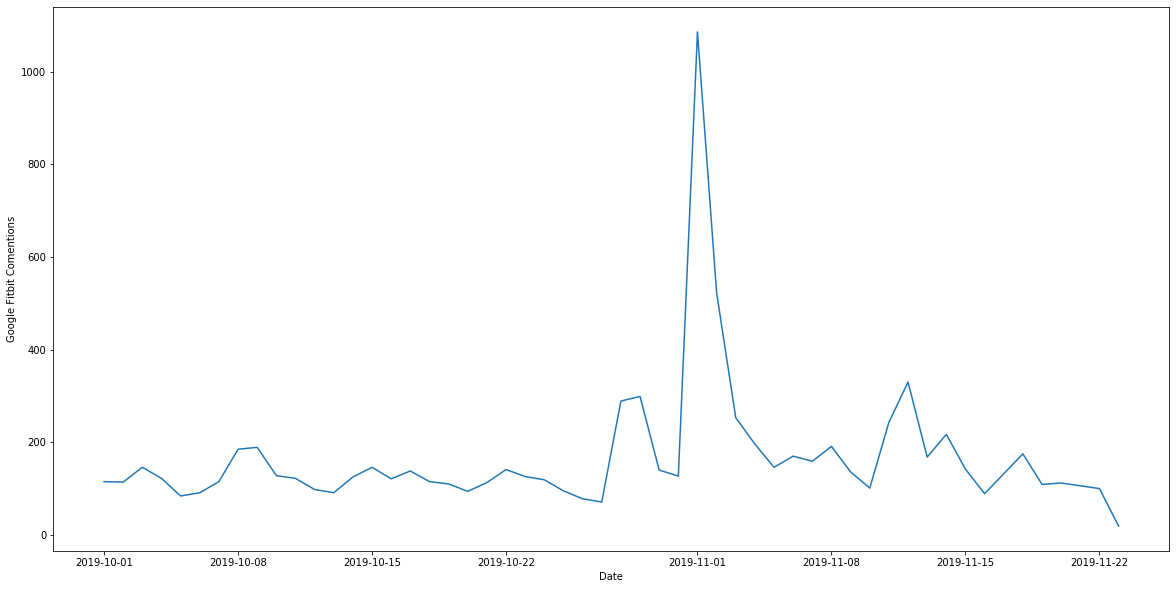

In [11]:
plt.figure(figsize=(20,10))
plt.plot(subset.groupby('day')['google_mention'].agg('count'))
plt.xlabel('Date')
plt.ylabel('Google Fitbit Comentions')
plt.show()

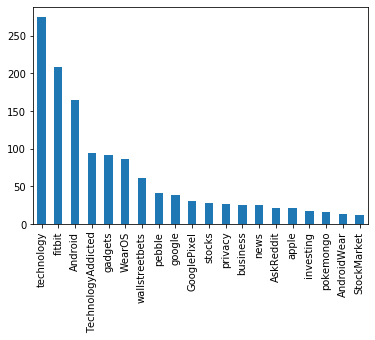

In [12]:
#subreddits with comentions
df_fitbit[df_fitbit['body'].str.contains('google', flags=re.IGNORECASE, regex=True)].subreddit.value_counts().iloc[:20].plot.bar()

## Let's try scaping subreddits with high co-mentions

In [51]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
mention_subs = df_fitbit[df_fitbit['body'].str.contains('google', flags=re.IGNORECASE, regex=True)].subreddit.value_counts().iloc[:15].index

In [53]:
%%time
df_list = []

for sub in mention_subs:

    gen = api.search_comments(after=int(dt.datetime(2019, 10, 22).timestamp()),
                              before = int(dt.datetime(2019, 11, 22).timestamp()),
                              limit = 50000,
                              subreddit = sub)


    df = pd.DataFrame([obj.d_ for obj in gen])  
    df_list.append(df)

Wall time: 14min 8s


In [54]:
[len(df) for df in df_list]

[50000,
 3028,
 50000,
 20368,
 33345,
 5078,
 50000,
 2810,
 7078,
 50000,
 19767,
 22683,
 10031,
 50000,
 50000]

In [55]:
df = pd.concat(df_list)

In [56]:
df['date'] = pd.to_datetime(df['created_utc'],unit='s').dt.date

In [61]:
subset = df[['date', 'subreddit', 'body', 'score']]
subset['mentions_google'] = df['body'].str.contains('google', flags=re.IGNORECASE, regex=True)
subset['mentions_fitbit'] = df['body'].str.contains('fitbit', flags=re.IGNORECASE, regex=True)
subset['comention'] = (subset['mentions_google'] == True) & (subset['mentions_fitbit'] == True)

In [65]:
subset.mentions_google.value_counts()

False    399506
True      24682
Name: mentions_google, dtype: int64

In [66]:
subset.mentions_fitbit.value_counts()

False    422307
True       1881
Name: mentions_fitbit, dtype: int64

In [68]:
subset.comention.value_counts()

False    423448
True        740
Name: comention, dtype: int64

In [62]:
comention = subset[subset['comention'] == True]

In [64]:
#comention by subreddit
comention.subreddit.value_counts()

fitbit                193
gadgets                97
TechnologyAddicted     94
WearOS                 85
technology             51
pebble                 42
google                 40
stocks                 32
privacy                31
GooglePixel            28
business               25
Android                20
news                    1
wallstreetbets          1
Name: subreddit, dtype: int64

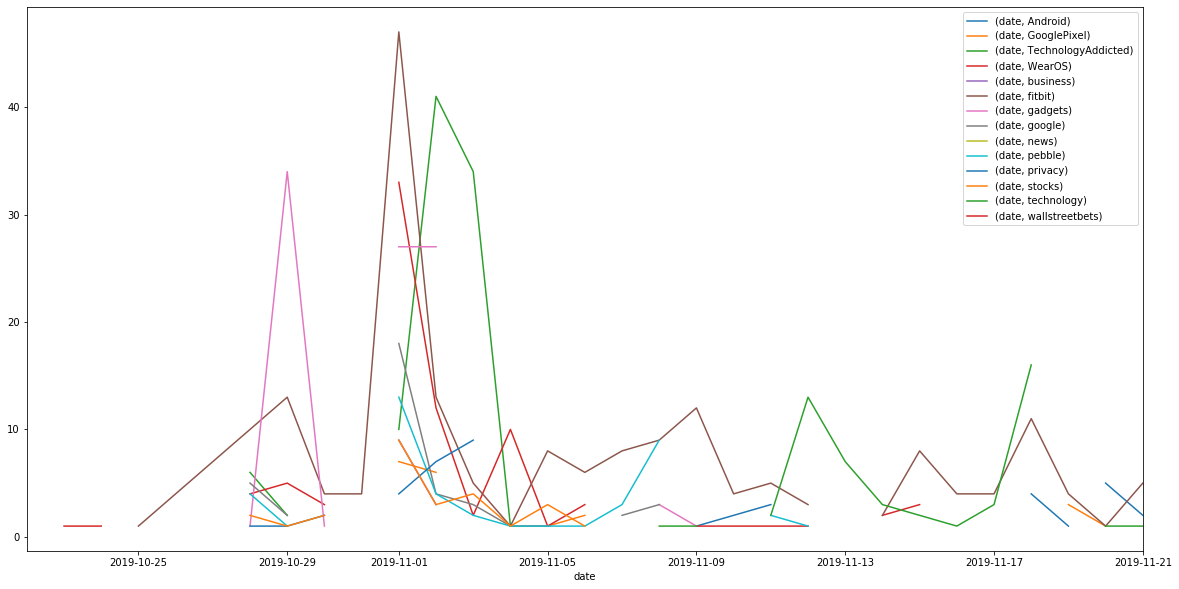

In [63]:
comention.groupby(['date', 'subreddit'])[['date']].agg('count').unstack().plot(figsize=(20,10))
plt.legend()
plt.show()